In [1]:
# Use STB dataset
# Create metrics
# Only the ht_p2 can be made trainable after CycleGan is trained. Depth -> Generator to RGB -> Decoder (ht_p2)
# and show performance. Thus transfer of information due to pre trained rgb weights.
# Thus having a well trained rgb model can be used for depth based prediction correction and vice versa.

In [2]:
import torchgan
import random
import torch
import glob, os
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
import PIL.Image as Image

%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  999


In [5]:
BATCH_SIZE = 10
EPOCHS = 500

In [6]:
from AWR.model.hourglass import PoseNet
from AWR.dataloader.nyu_loader import NYU
from AWR.config import opt
from HandTailor.demo import *
from util import dotdict

pygame 2.0.1 (SDL 2.0.14, Python 3.7.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


/Users/debabratamandal/Jun-Dec 2021/rnd/exp/HandTailor


In [7]:
class AWR_P1(nn.Module):
    def __init__(self, opt):
        super(AWR_P1, self).__init__()
        self.config = opt
        self.stacks = int(self.config.net.split('_')[1])
        self.net = PoseNet(self.config.net, self.config.jt_num)
        self.init_weights() 

    def init_weights(self):
        print('loading model from %s' % self.config.load_model)
        pth = torch.load(self.config.load_model, map_location=torch.device('cpu'))
        self.net.load_state_dict(pth['model'])
        
    def make_trainable(self):
        for idx, param in enumerate(self.net.parameters()):
            l = len(list(self.net.parameters()))
            if idx != l-2 and idx != l-4:
                param.requires_grad = False
            else:
                param.requires_grad = False

    def forward(self, img, jt_xyz_gt, jt_uvd_gt, center_xyz, M, cube):
        return self.net(img)[self.stacks-1], img, center_xyz, M, cube

awr_p1 = AWR_P1(opt).eval()
awr_p1.make_trainable()
base_awr_p1 = AWR_P1(opt).eval()

for params in awr_p1.parameters():
    if params.requires_grad:
        print(f"{params.shape} requires grad")

loading model from /Users/debabratamandal/Jun-Dec 2021/rnd/exp/AWR/results/hourglass_1.pth
loading model from /Users/debabratamandal/Jun-Dec 2021/rnd/exp/AWR/results/hourglass_1.pth


In [8]:
from AWR.util.feature_tool import FeatureModule
class AWR_P2(nn.Module):
    def __init__(self, opt):
        super(AWR_P2, self).__init__()
        self.config = opt
        self.ft_sz = int(self.config.img_size / self.config.downsample)
        self.FM = FeatureModule()
    
    def generate_gt(self, img, jt_xyz_gt, jt_uvd_gt, center_xyz, M, cube):
        offset_gt = self.FM.joint2offset(jt_uvd_gt, img, self.config.kernel_size, self.ft_sz)
        return torch.Tensor(offset_gt), torch.Tensor(jt_uvd_gt)
    
    def forward(self, offset_pred, img, center_xyz, M, cube):
        jt_uvd_pred = self.FM.offset2joint_softmax(offset_pred, img, self.config.kernel_size)
        return offset_pred, jt_uvd_pred
    
awr_p2 = AWR_P2(opt).eval()
# get offset_gt from the dataset

In [9]:
from jax import grad, jit, vmap
from jax.experimental import optimizers
import jax.numpy as npj
from HandTailor.model import Hand2D, BottleneckBlock, HandNet
from HandTailor.demo import residuals, mano_layer
class Handtailor_P1(nn.Module):
    def __init__(self, model, **kwargs):
        super(Handtailor_P1, self).__init__()
        self.model = model
    
    def make_trainable(self):
        for idx, (name, params) in enumerate(model.named_parameters()):
#             l = len(list(self.model.parameters()))
            if "fc" in name:
                params.requires_grad = False #True
            else:
                params.requires_grad = False
    
    def forward(self, frame, img, intr):
#         print("Image", img)
        hm, enc = self.model(img)
#         print("HMM", hm[-1].shape, enc[0].shape, frame)
        return (hm, enc), frame, intr

# Load from pretrained model
model = HandNet()
model = model.to(device)
checkpoint_io = CheckpointIO(file_dir, model=model)
load_dict = checkpoint_io.load(os.path.join(file_dir, 'checkpoints/model.pt'))

kw = {'nstacks':2 , 'nblocks':1, 'njoints':21, 'block':BottleneckBlock}

ht_p1 = Handtailor_P1(model.hand3d.hand2d, **kw).eval()
ht_p1.make_trainable()

base_ht_p1 = Handtailor_P1(model.hand3d.hand2d, **kw).eval()

for params in ht_p1.parameters():
    print(f"{params.shape}", params.requires_grad)
    
for c in ht_p1.children():
    print(c)

/Users/debabratamandal/Jun-Dec 2021/rnd/exp/HandTailor/checkpoints/model.pt
=> Loading checkpoint from local file...
torch.Size([64, 3, 7, 7]) False
torch.Size([64]) False
torch.Size([64]) False
torch.Size([64]) False
torch.Size([64, 64, 1, 1]) False
torch.Size([64]) False
torch.Size([64]) False
torch.Size([64]) False
torch.Size([64, 64, 3, 3]) False
torch.Size([64]) False
torch.Size([64]) False
torch.Size([64]) False
torch.Size([128, 64, 1, 1]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([128, 64, 1, 1]) False
torch.Size([128]) False
torch.Size([128, 128, 1, 1]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([128, 128, 3, 3]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([128]) False
torch.Size([256, 128, 1, 1]) False
torch.Size([256]) False
torch.Size([256]) False
torch.Size([256]) False
torch.Size([256, 128, 1, 1]) False
torch.Size([256]) False
torch.Size([128, 256, 1, 1]) False

In [10]:
import torchinfo

In [11]:
torchinfo.summary(model.hand3d.hand2d.hg2b[0])

Layer (type:depth-idx)                        Param #
Hourglass                                     --
├─ModuleList: 1-1                             --
│    └─ModuleList: 2-1                        --
│    │    └─Sequential: 3-1                   (214,528)
│    │    └─Sequential: 3-2                   (214,528)
│    │    └─Sequential: 3-3                   (214,528)
│    │    └─Sequential: 3-4                   (214,528)
│    └─ModuleList: 2-2                        --
│    │    └─Sequential: 3-5                   (214,528)
│    │    └─Sequential: 3-6                   (214,528)
│    │    └─Sequential: 3-7                   (214,528)
│    └─ModuleList: 2-3                        --
│    │    └─Sequential: 3-8                   (214,528)
│    │    └─Sequential: 3-9                   (214,528)
│    │    └─Sequential: 3-10                  (214,528)
│    └─ModuleList: 2-4                        --
│    │    └─Sequential: 3-11                  (214,528)
│    │    └─Sequential: 3-12        

In [12]:
# for i, k in ht_p2.model.hand3d.hand2dto3d.state_dict().items():
#     print(i, torch.mean(k))
def uvd2xyz1(pts, paras, flip=1):
    # paras: (fx, fy, fu, fv)
    pts_xyz = pts.copy()
    pts_xyz = pts_xyz.reshape(-1, 3).copy()
    pts_xyz[:, :2] = (pts_xyz[:, :2] - paras[2:]) * pts_xyz[:, 2:] / paras[:2]
    pts_xyz[:, 1] *= flip

    return pts_xyz.reshape(pts.shape).astype(np.float32)

In [13]:
class HandTailor_P2(nn.Module):
    def __init__(self, model, custom=True):
        super(HandTailor_P2, self).__init__()
        self.model = HandNet(custom=custom)
        
    def init_weights(self, saved_model):
#         self.model.decoder = saved_model.decoder
        self.model.ref_bone_link = saved_model.ref_bone_link
        self.model.joint_root_idx = saved_model.joint_root_idx
        self.model.hand3d.hand2dto3d.load_state_dict(saved_model.hand3d.hand2dto3d.state_dict())
        self.model.decoder.load_state_dict(saved_model.decoder.state_dict())
        self.model.iknet.load_state_dict(saved_model.iknet.state_dict())
        self.model.sigmoid.load_state_dict(saved_model.sigmoid.state_dict())
        self.model.shapereg_layers.load_state_dict(saved_model.shapereg_layers.state_dict())

    def make_trainable(self):
        for idx, param in enumerate(self.model.parameters()):
#             l = len(list(self.model.parameters()))
            param.requires_grad = False

    def forward(self, x, frame, intr):
        hm, so3, beta, joint_root, bone = self.model(x, intr)
#         print("HM", hm)
        batch_size = intr.shape[0]
        camparam = np.zeros((batch_size, 21, 4))
#         print(intr)
        camparam[:, :, 0] = np.reshape(intr[:, 0, 0], (batch_size, 1))
        camparam[:, :, 1] = np.reshape(intr[:, 1, 1], (batch_size, 1))
        camparam[:, :, 2] = np.reshape(intr[:, 0, 2], (batch_size, 1))
        camparam[:, :, 3] = np.reshape(intr[:, 1, 2], (batch_size, 1))
        _so3 = so3
        _beta = beta
        bone = bone[0]
        joint_root = joint_root[0]
        so3 = np.array(so3[0].detach())
        beta = np.array(beta[0].detach())
        joint = mano_de_j(so3, beta)
#         print(joint*256, uvd2xyz1(joint, camparam[0, 0, :]))
        return joint, hm, camparam, bone, joint_root, _so3, _beta, frame, intr

kw = {'custom': True}
ht_p2 = HandTailor_P2(model, **kw)
ht_p2.make_trainable()
ht_p2.eval()
ht_p2.init_weights(model)

# for i, k in model.hand3d.hand2dto3d.state_dict().items():
#     print(i, torch.mean(k))
# print(model.hand3d.hand2dto3d.state_dict())

test = torch.rand([1, 256, 64, 64])
# print(torch.mean(model.hand3d.hand2dto3d(test)[0]))
# print(torch.mean(ht_p2.model.hand3d.hand2dto3d(test)[0]))

for params in ht_p2.parameters():
#     if params.requires_grad:
    print(f"{params.shape} requires grad")
    
    
for c in ht_p2.children():
    print(c)

torch.Size([128, 256, 1, 1]) requires grad
torch.Size([128]) requires grad
torch.Size([128]) requires grad
torch.Size([128]) requires grad
torch.Size([128, 128, 3, 3]) requires grad
torch.Size([128]) requires grad
torch.Size([128]) requires grad
torch.Size([128]) requires grad
torch.Size([256, 128, 1, 1]) requires grad
torch.Size([256]) requires grad
torch.Size([256]) requires grad
torch.Size([256]) requires grad
torch.Size([128, 256, 1, 1]) requires grad
torch.Size([128]) requires grad
torch.Size([128]) requires grad
torch.Size([128]) requires grad
torch.Size([128, 128, 3, 3]) requires grad
torch.Size([128]) requires grad
torch.Size([128]) requires grad
torch.Size([128]) requires grad
torch.Size([256, 128, 1, 1]) requires grad
torch.Size([256]) requires grad
torch.Size([256]) requires grad
torch.Size([256]) requires grad
torch.Size([128, 256, 1, 1]) requires grad
torch.Size([128]) requires grad
torch.Size([128]) requires grad
torch.Size([128]) requires grad
torch.Size([128, 128, 3, 3]

In [14]:
def ht_p3(joint, hm, camparam, bone, joint_root, so3, beta, frame, intr):
#     print("hand3d", torch.mean(hm), torch.mean(so3))
    kp2d = hm_to_kp2d(hm.detach().numpy())*4
    kp2d = npj.array(kp2d)
    so3 = npj.array(so3[0].detach())
    beta = npj.array(beta[0].detach())
    joint_root = npj.array(joint_root.detach())
    joint_root = reinit_root(joint_root,kp2d, camparam)
    bone = npj.array(bone.detach())
    gr = jit(grad(residuals))
    lr = 0.03
    opt_init, opt_update, get_params = optimizers.adam(lr, b1=0.5, b2=0.5)
    opt_init = jit(opt_init)
    opt_update = jit(opt_update)
    get_params = jit(get_params)
    so3_init = so3
    beta_init = beta
    bone = reinit_scale(joint,kp2d,camparam,bone,joint_root)
    params = {'so3':so3, 'beta':beta, 'bone':bone}
    opt_state = opt_init(params)
    n = 0
    while n < 20:
        n = n + 1
        params = get_params(opt_state)
        grads = gr(params,so3_init,beta_init,joint_root,kp2d,camparam)
        opt_state = opt_update(n, grads, opt_state)
    params = get_params(opt_state)
    v = mano_de(params,joint_root,bone)
#     print(torch.mean(torch.Tensor(np.array(v))))
    return v, intr, frame

In [15]:
root_dir = os.path.curdir
awr_dir = os.path.join(root_dir, 'AWR/')
os.makedirs(awr_dir, exist_ok=True)

handtailor_dir = os.path.join(root_dir, 'HandTailor/')
os.makedirs(handtailor_dir, exist_ok=True)

data_dir = os.path.join(root_dir, 'data/')
awr_data_dir = os.path.join(data_dir, 'nyu/')
ht_data_dir = os.path.join(data_dir, 'RHD_published_v2/')

fig_dir = os.path.join(root_dir, 'figures/')
os.makedirs(fig_dir, exist_ok=True)

awr_fig_dir = os.path.join(fig_dir, 'awr/')
ht_fig_dir = os.path.join(fig_dir, 'handtailor/')

In [16]:
class CombinedImageDataset(Dataset):
    def __init__(self, dataset_A, dataset_B, gt_A, gt_B, mode="train"):
        self.dataset_A = dataset_A
        self.dataset_B = dataset_B
        self.gt_A = gt_A
        self.gt_B = gt_B
        
    def __getitem__(self, index):
        # Hardcode
#         index = 23
#         print(index)
        item_A = self.dataset_A[index % len(self.dataset_A)]
        item_B = self.dataset_B[index % len(self.dataset_B)]
#         print(index, len(self.dataset_A))
        gt_A = self.gt_A[index // BATCH_SIZE][index % BATCH_SIZE]
        gt_B = self.gt_B[index // BATCH_SIZE][index % BATCH_SIZE]
#         return {"A": item_A, "gt_A": gt_A, "B": item_B, "gt_B": gt_B}
        return (item_A, gt_A, item_B, gt_B)
    
    def __len__(self):
        return max(len(self.dataset_A), len(self.dataset_B))

In [17]:
# Load dataset A - AWR

awr_data_dir = os.path.join(opt.data_dir, opt.dataset)
d1 = NYU(awr_data_dir, 'test', img_size=opt.img_size, cube=opt.cube)
# print(d1[0])
[x.shape for x in d1[0]]

loading dataset, containing 99 images.


[(1, 128, 128), (14, 3), (14, 3), (3,), (3, 3), (3,)]

In [18]:
# Generate ground truth annotations A
# d1_loader = DataLoader(d1, batch_size=BATCH_SIZE, drop_last=True, shuffle=False)
d1_loader = DataLoader(d1, batch_size=BATCH_SIZE, drop_last=True, shuffle=False)
gt_A = []
for i in range(len(d1_loader)):
    _gt = next(iter(d1_loader))
    offset_gt, jt_uvd_gt = awr_p2.generate_gt(*_gt)
    gt_A += [jt_uvd_gt]

len(gt_A)
len(d1_loader)
# with open(os.path.join(awr_data_dir, 'gt_A.npy'), 'wb') as gt_A:
#     np.save(gt_A, np.array(gt))

9

In [19]:
ht_set = "evaluation"
ht_eval_dir = os.path.join(ht_data_dir, ht_set)
with open(os.path.join(ht_eval_dir, 'anno_%s.pickle' % ht_set), 'rb') as fi:
    anno_all = pickle.load(fi)
print(len(anno_all), anno_all[0].keys(), anno_all[0]['K'])
print(np.mean(anno_all[0]['uv_vis']))
print(anno_all[0]['uv_vis'])

2728 dict_keys(['K', 'xyz', 'uv_vis']) [[282.9   0.  160. ]
 [  0.  282.9 160. ]
 [  0.    0.    1. ]]
81.75114
[[158.    136.9     1.   ]
 [153.2   174.7     1.   ]
 [150.4   166.3     1.   ]
 [147.4   154.      1.   ]
 [151.4   145.4     1.   ]
 [170.6   174.9     1.   ]
 [167.4   167.9     1.   ]
 [163.8   158.3     1.   ]
 [159.2   150.5     1.   ]
 [171.8   191.3     1.   ]
 [172.7   177.4     1.   ]
 [173.1   164.3     1.   ]
 [169.6   151.9     1.   ]
 [177.3   188.6     1.   ]
 [178.2   174.8     1.   ]
 [178.6   163.7     1.   ]
 [175.8   152.9     1.   ]
 [188.4   182.6     1.   ]
 [188.2   175.2     1.   ]
 [187.5   167.2     1.   ]
 [181.4   155.1     1.   ]
 [-13.56  152.5     0.   ]
 [ -2.058 181.6     0.   ]
 [ -1.16  177.3     0.   ]
 [ -2.59  166.5     0.   ]
 [ -4.869 158.1     0.   ]
 [-17.24  196.5     0.   ]
 [-18.19  187.6     0.   ]
 [-20.05  175.7     0.   ]
 [-17.54  165.8     0.   ]
 [-38.35  200.4     0.   ]
 [-34.96  190.9     0.   ]
 [-33.55  181.      0.  

In [20]:
# Load dataset B  - HandTailor

# experimental
# ht_data_dir = os.path.join(opt.data_dir, opt.dataset)

import imageio

class HandTailorDataset(Dataset):
    def __init__(self, img_dir, anno_all, mode="train"):
#         self.img_list = sorted(glob.glob(os.path.join(img_dir, '*.*')))
        self.img_list = [os.path.join(img_dir, 'color', '%.5d.png' % idx) for idx, _ in anno_all.items()]
        self.anno = [anno for _, anno in anno_all.items()]
        self.mode = mode
    
    def transform(self, img, K):
#         if flip:
#             img = np.flip(img, 1)
        frame, img, intr = preprocess(img, dotdict({'cx':K[0, 2], 'cy':K[1, 2], 'fx':K[0, 0], 'fy':K[1, 1]}))
        return frame, img[0], intr[0]
        
    def __getitem__(self, index):
#         index = 23
        index = index % len(self.img_list)
#         print(self.anno[index]['xyz'])
#         flip = self.anno[index]['uv_vis'][0, 2]
#         print(flip, "fli")
        return self.transform(imageio.imread(self.img_list[index]), self.anno[index]['K']), self.anno[index]
    
    def __len__(self):
        return len(self.img_list)
        
# arg = {'cx': 321.2842102050781, 'cy': 235.8609161376953, 'fx': 612.0206298828125, 'fy': 612.2821044921875}
d2 = HandTailorDataset(ht_eval_dir, anno_all, mode="test")
# d2 = HandTailorDataset('HandTailor/demo/', dotdict(arg), mode="test")

assert(len(d2[-1][-2]) == 3)
[x.shape for x in d2[-1][-2]]

len(d2)

2728

In [21]:
# Generate ground truth annotations B

SCALE = 256 / 320

def generate_gt_B(anno):
    gt_xyz = []
    gt_uv_proj = []
    gt_vs = []
    gt_uv = []
    for idx in range(len(anno['K'])):
        kp_coord_uv = anno['uv_vis'][idx][:, :2]
        kp_visible = (anno['uv_vis'][idx][:, 2] == 1) * 1.0
        kp_coord_xyz = anno['xyz'][idx]

        camera_intrinsic_matrix = anno['K'][idx]

        kp_coord_uv_proj = np.matmul(kp_coord_xyz, np.transpose(camera_intrinsic_matrix))
        kp_coord_uv_proj = kp_coord_uv_proj[:, :2] / kp_coord_uv_proj[:, 2:]
#         gt.append((kp_coord_xyz, kp_coord_uv_proj))
        gt_xyz.append(torch.Tensor(kp_coord_xyz))
        gt_uv_proj.append(torch.Tensor(kp_coord_uv_proj)*SCALE)
        gt_vs.append(torch.Tensor(kp_visible))
        gt_uv.append(torch.Tensor(kp_coord_uv)*SCALE)
    
    return gt_xyz, gt_uv, gt_vs, gt_uv_proj

# Need a batch size of 2
d2_loader = DataLoader(d2, batch_size=BATCH_SIZE, drop_last=True, shuffle=False)
gt_B = []
for i in range(len(d2_loader)):
    _, y = next(iter(d2_loader))
    gt_xyz, *_ = generate_gt_B(y)
    gt_B += [gt_xyz]
#     *_, _gt_jt_root, _gt_so3, _gt_beta, _, _ = ht_p2(*base_ht_p1.forward(*_gt))
#     gt_B.append(_gt_beta[0])
#     gt_B.append(_gt_beta[1])

# with open(os.path.join(data_dir, 'gt_B.npy'), 'wb') as gt_B:
#     np.save(gt_B, np.array(gt))

In [22]:
print(len(gt_B))

272


In [23]:
test_ds = CombinedImageDataset(d1, d2, gt_A, gt_B)
len(test_ds)

assert test_ds[0]

0 99


In [24]:
dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, drop_last=True, shuffle=False)

In [25]:
a = next(iter(dataloader))
a

0 99
1 99
2 99
3 99
4 99
5 99
6 99
7 99
8 99
9 99


[[tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            ...,
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.]]],
  
  
          [[[1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            ...,
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.]]],
  
  
          [[[1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            ...,
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.]]],
  
  
          ...,
  
  
          [[[1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,

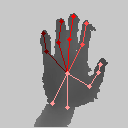

In [26]:
from AWR.util.vis_tool import VisualUtil

vis_tool = VisualUtil(opt.dataset)
img = a[0][0].detach().cpu().numpy()
jt_uvd_gt = (a[0][2] + 1) * opt.img_size / 2
vis_tool.plot(img[0], os.path.join(awr_dir, 'sample.png'), jt_uvd_gt, jt_uvd_gt)

Image.open(os.path.join(awr_dir, 'sample.png'))

{'K': tensor([[[282.9000,   0.0000, 160.0000],
         [  0.0000, 282.9000, 160.0000],
         [  0.0000,   0.0000,   1.0000]],

        [[294.3000,   0.0000, 160.0000],
         [  0.0000, 294.3000, 160.0000],
         [  0.0000,   0.0000,   1.0000]],

        [[277.4000,   0.0000, 160.0000],
         [  0.0000, 277.4000, 160.0000],
         [  0.0000,   0.0000,   1.0000]],

        [[270.3000,   0.0000, 160.0000],
         [  0.0000, 270.3000, 160.0000],
         [  0.0000,   0.0000,   1.0000]],

        [[286.6000,   0.0000, 160.0000],
         [  0.0000, 286.6000, 160.0000],
         [  0.0000,   0.0000,   1.0000]],

        [[283.8000,   0.0000, 160.0000],
         [  0.0000, 283.8000, 160.0000],
         [  0.0000,   0.0000,   1.0000]],

        [[278.3000,   0.0000, 160.0000],
         [  0.0000, 278.3000, 160.0000],
         [  0.0000,   0.0000,   1.0000]],

        [[281.9000,   0.0000, 160.0000],
         [  0.0000, 281.9000, 160.0000],
         [  0.0000,   0.0000,   1.000

/Users/debabratamandal/Jun-Dec 2021/rnd/ganed/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if __name__ == '__main__':
/Users/debabratamandal/Jun-Dec 2021/rnd/ganed/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


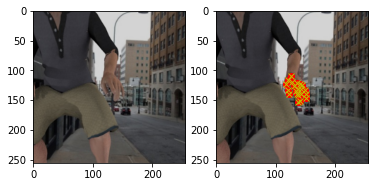

In [27]:
import cv2

def view_samples(image, kp_coord_uv, kp_coord_uv_proj, kp_visible):
    fig = plt.figure(1)
    kp_coord_uv_proj = kp_coord_uv_proj
    kp_coord_uv = kp_coord_uv
#     print(kp_coord_uv, kp_coord_uv_proj, kp_visible)
    kp_visible = kp_visible.numpy().astype(bool)
    ax1 = fig.add_subplot('121')
    ax2 = fig.add_subplot('122')

    ax1.imshow(image)
    ax2.imshow(image)
    ax2.plot(kp_coord_uv[kp_visible, 0], kp_coord_uv[kp_visible, 1], 'ro')
    ax2.plot(kp_coord_uv_proj[kp_visible, 0], kp_coord_uv_proj[kp_visible, 1], 'yx')
        

    plt.show()
# a = next(iter(dataloader))
frame = a[2][0][0][0]
print(a[2][1])
kp_coord_xyz, kp_coord_uv, kp_visible, kp_coord_uv_proj = generate_gt_B(a[2][1])
view_samples(frame, kp_coord_uv[0], kp_coord_uv_proj[0], kp_visible[0])
# cv2.imwrite(os.path.join(handtailor_dir, "sample_image.png"), np.flip(frame.numpy(),-1))
# Image.open(os.path.join(handtailor_dir, 'sample_image.png'))

In [28]:
# Tests A
A = a[0]
x, *out = base_awr_p1(*A)
offset_pred, jt_uvd_pred = awr_p2(x, *out)

img = A[0].detach().cpu().numpy()
jt_uvd_gt = (A[2] + 1) * opt.img_size / 2
jt_uvd_pred = (jt_uvd_pred + 1) * opt.img_size / 2

print(torch.max(jt_uvd_gt-jt_uvd_pred)/torch.max(jt_uvd_gt))
print("Latent dimension A: ", x.shape)

/Users/debabratamandal/Jun-Dec 2021/rnd/ganed/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(0.0187, grad_fn=<DivBackward0>)
Latent dimension A:  torch.Size([10, 56, 64, 64])


In [29]:
# Tests B
B = a[2][0]
out = base_ht_p1(*B)
print("Latent dimension B: ", out[0][1][-1].shape)

Latent dimension B:  torch.Size([10, 256, 64, 64])


In [30]:
out = ht_p2(*out)

[[ 0.07879972 -0.05361107  1.0589343 ]
 [ 0.08234761 -0.05176029  1.0758961 ]
 [ 0.07978435 -0.0481336   1.0684886 ]
 ...
 [ 0.03139156 -0.0144414   1.0525373 ]
 [ 0.02208602 -0.01890121  1.0412778 ]
 [ 0.04817809 -0.02367397  1.0746964 ]] tensor([[226.3200,   0.0000, 128.0000],
        [  0.0000, 226.3200, 128.0000],
        [  0.0000,   0.0000,   1.0000]])


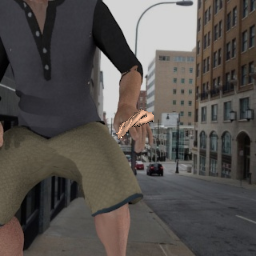

In [31]:
import pickle
from HandTailor.utils import MeshRenderer

dd = pickle.load(open(os.path.join(file_dir, "MANO_RIGHT.pkl"), 'rb'), encoding='latin1')
face = np.array(dd['f'])

v, intr, frame = ht_p3(*out)
v = np.array(v)
intr = intr[0].cpu()
frame = frame.numpy()[0]
print(v, intr)

# v = np.load("./some.npy")
renderer = MeshRenderer(face, img_size=256)
frame1 = renderer(v, intr, frame)
cv2.imwrite(os.path.join(handtailor_dir, 'sample.png'), np.flip(frame1,-1))
Image.open(os.path.join(handtailor_dir, 'sample.png'))

In [32]:
numc_awr = 56
numc_ht = 256

In [33]:
torch.autograd.set_detect_anomaly(True)

### CycleGAN

In [34]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.conv_block(x)

In [35]:
class CycleGANGenerator(nn.Module):
    def __init__(self, image_batch, in_channels=3, out_channels=3, res_blocks=5):
        super(CycleGANGenerator, self).__init__()
        self.encoding_dims = in_channels

        self.image_batch = image_batch

        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 4, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(res_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 4, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [nn.ReflectionPad2d(3), nn.Conv2d(64, out_channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

        self._weight_initializer()

    def _weight_initializer(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        return self.model(x)
    
gan_a2b = CycleGANGenerator(BATCH_SIZE, numc_awr, numc_ht)
gan_b2a = CycleGANGenerator(BATCH_SIZE, numc_ht, numc_awr)

In [36]:
A, gt_A, B, gt_B = a
lat_A, *others_A = awr_p1(*A)
lat_B, *others_B = ht_p1(*B[0])
print(lat_A.shape)
assert( gan_a2b(lat_A).shape == lat_B[1][-1].shape )
assert( gan_b2a(lat_B[1][-1]).shape == lat_A.shape )

torch.Size([10, 56, 64, 64])


In [37]:
class CycleGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(CycleGANDiscriminator, self).__init__()
        
        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

        self._weight_initializer()

    def _weight_initializer(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        return self.model(x)

disc_a = CycleGANDiscriminator(numc_awr)
disc_b = CycleGANDiscriminator(numc_ht)

In [38]:
x = disc_b(gan_a2b(lat_A))
y = disc_a(gan_b2a(lat_B[1][-1]))
print(x.shape, y.shape)
# print(x.isnan(), lat_A.isnan(), y.isnan())

torch.Size([10, 1, 4, 4]) torch.Size([10, 1, 4, 4])


In [39]:
from torchgan.losses import least_squares_generator_loss, least_squares_discriminator_loss

In [40]:
import torch.optim as optim
optim_disc_a = optim.Adam(disc_a.parameters(), lr=0.0001, betas=(0.5, 0.999))
optim_disc_b = optim.Adam(disc_b.parameters(), lr=0.0001, betas=(0.5, 0.999))
optim_gan_a2b = optim.Adam(gan_a2b.parameters(), lr=0.0001, betas=(0.5, 0.999))
optim_gan_b2a = optim.Adam(gan_b2a.parameters(), lr=0.0001, betas=(0.5, 0.999))

# optim_awr = optim.Adam(awr_p1.parameters(), lr=0.0001, betas=(0.5, 0.999))
# optim_ht = optim.Adam(ht_p1.parameters(), lr=0.0001, betas=(0.5, 0.999))


a = sum(p.numel() for p in disc_a.parameters())
b = sum(p.numel() for p in disc_b.parameters())
c = sum(p.numel() for p in gan_a2b.parameters())
d = sum(p.numel() for p in gan_b2a.parameters())

print(a, c)

2819009 8190848


In [41]:
def CycleGANGeneratorLoss(
        gen_a2b,
        gen_b2a,
        dis_a,
        dis_b,
        optimizer_gen_a2b,
        optimizer_gen_b2a,
        image_a,
        image_b,
    ):
        optimizer_gen_a2b.zero_grad()
        optimizer_gen_b2a.zero_grad()
        fake_a = gen_b2a(image_b)
        fake_b = gen_a2b(image_a)
        loss_identity_a2b = 0.5 * F.l1_loss(fake_b, image_b)
        loss_identity_b2a = 0.5 * F.l1_loss(fake_a, image_a)
#         loss_identity = 0.5 * (F.l1_loss(fake_a, image_a) + F.l1_loss(fake_b, image_b))
        loss_gan_a2b = 0.5 * least_squares_generator_loss(dis_b(fake_b))
        loss_gan_b2a = 0.5 * least_squares_generator_loss(dis_a(fake_a))
#         loss_gan = 0.5 * (
#             least_squares_generator_loss(dis_a(fake_a))
#             + least_squares_generator_loss(dis_b(fake_b))
#         )
        loss_cycle_consistency = 0.5 * (
            F.l1_loss(gen_a2b(fake_a), image_b) + F.l1_loss(gen_b2a(fake_b), image_a)
        )
#         loss = loss_identity + loss_gan + loss_cycle_consistency
        loss = loss_identity_a2b + loss_identity_b2a + loss_gan_a2b + loss_gan_b2a + loss_cycle_consistency
        loss.backward(retain_graph=True)
        optimizer_gen_a2b.step()
        optimizer_gen_b2a.step()
        return loss.item(), loss_identity_a2b.item(), loss_identity_b2a.item(), loss_gan_a2b.item(), loss_gan_b2a.item(), loss_cycle_consistency.item()

loss = CycleGANGeneratorLoss(gan_a2b, gan_b2a, disc_a, disc_b, optim_gan_a2b, optim_gan_b2a, lat_A, lat_B[1][-1])

In [42]:
def CycleGANDiscriminatorLoss(
        gen_a2b,
        gen_b2a,
        dis_a,
        dis_b,
        optimizer_dis_a,
        optimizer_dis_b,
        image_a,
        image_b,
    ):
        optimizer_dis_a.zero_grad()
        optimizer_dis_b.zero_grad()
        fake_a = gen_b2a(image_b).detach()
        fake_b = gen_a2b(image_a).detach()
        loss_b2a = 0.5 * least_squares_discriminator_loss(dis_a(image_a), dis_a(fake_a))
        loss_a2b = 0.5 * least_squares_discriminator_loss(dis_b(image_b), dis_b(fake_b))
#         loss = 0.5 * (
#             least_squares_discriminator_loss(dis_a(image_a), dis_a(fake_a))
#             + least_squares_discriminator_loss(dis_b(image_b), dis_b(fake_b))
#         )
        loss = loss_a2b + loss_b2a
        loss.backward(retain_graph=True)
        optimizer_dis_a.step()
        optimizer_dis_b.step()
        return loss.item(), loss_a2b.item(), loss_b2a.item()
    
loss = CycleGANDiscriminatorLoss(gan_a2b, gan_b2a, disc_a, disc_b, optim_disc_a, optim_disc_b, lat_A, lat_B[1][-1])

In [43]:
def RMSE(prediction, target):
    loss_fn = nn.MSELoss()
    RMSE_loss = torch.sqrt(loss_fn(prediction, target))
#     RMSE_loss.backward(retain_graph=True)

    return RMSE_loss.item()

In [44]:
#a -> AWR (Depth), b -> Handtailor (RGB)

def train_step(A, gt_A, B, gt_B):
# a = A, gt_A, B, gt_B
    lat_A, *others_A = awr_p1(*A)
    lat_B, *others_B = ht_p1(*B[0])

    _, out_A = awr_p2(lat_A, *others_A)
    *_, _gt_jt_root, _gt_so3, _gt_beta, _, _ = ht_p2(lat_B, *others_B)

    gan_loss = CycleGANGeneratorLoss(gan_a2b, gan_b2a, disc_a, disc_b, optim_gan_a2b, optim_gan_b2a, lat_A, lat_B[1][-1])
    disc_loss = CycleGANDiscriminatorLoss(gan_a2b, gan_b2a, disc_a, disc_b, optim_disc_a, optim_disc_b, lat_A, lat_B[1][-1])

#     optim_awr.zero_grad()
#     optim_ht.zero_grad()
    
    #Calculate metrics
    # print(_gt_so3, gt_B)
#     awr_loss = RMSE(out_A, gt_A)
#     ht_loss = RMSE(_gt_beta, gt_B)

#     optim_awr.step()
#     optim_ht.step()

#     return {"GAN Loss": gan_loss, "Discriminator loss": disc_loss, "AWR loss": awr_loss, "HT loss": ht_loss}
    return {"GAN Loss": gan_loss[0], "Discriminator loss": disc_loss[0]}, gan_loss, disc_loss

In [45]:
torch.autograd.set_detect_anomaly(True)

In [46]:
gan_losses = []
disc_losses = []
for epoch in range(EPOCHS):
    start = time.time()
    n = 0
    for data in dataloader:
        loss = train_step(*data)
        gan_losses.append(loss[1])
        disc_losses.append(loss[2])
        print(loss[0])
#         if n % 10 == 0:
#             print ('.', end='')
#         n += 1
#         break
    if (epoch + 1) % 5 == 0:
        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

0 99
1 99
2 99
3 99
4 99
5 99
6 99
7 99
8 99
9 99
{'GAN Loss': 2.2462985515594482, 'Discriminator loss': 3.0547869205474854}
10 99
11 99
12 99
13 99
14 99
15 99
16 99
17 99
18 99
19 99
{'GAN Loss': 1.865211009979248, 'Discriminator loss': 2.183131217956543}
20 99
21 99
22 99
23 99
24 99
25 99
26 99
27 99
28 99
29 99


KeyboardInterrupt: 

In [ ]:
# a - Depth, b - RGB
# loss_identity_a2b, loss_identity_b2a, loss_gan_a2b, loss_gan_b2a, loss_cycle_consistency
# Epoch 1
print(gan_losses[0][1:])
# Epoch 500
print(gan_losses[-1][1:])

In [ ]:
# a - Depth, b - RGB
# loss_a2b, loss_b2a
# Epoch 1
print(disc_losses[0][1:])
# Epoch 500
print(disc_losses[-1][1:])

In [ ]:
for data in dataloader:
    a = data[0]
#     print(len(a))
    out = gan_a2b(awr_p1(*data[0])[0]).detach().numpy()
    bre